# Training a image classifier

In [2]:
# load and normalizae CIFAR10

import torch
import torchvision
from torchvision import transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

bs = 4
train_ds = torchvision.datasets.CIFAR10(root='./data',train=True, download=True, transform=transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
test_ds = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


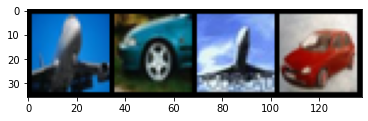

plane car   plane car  


In [23]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_dl)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images, normalize=True))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(bs)))

In [28]:
# Define CNN

from torch import nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 120)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
        

In [29]:
# Define Loss Function, Optimizer

from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [32]:
# Train the network

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.440
[1,  4000] loss: 1.901
[1,  6000] loss: 1.721
[1,  8000] loss: 1.620
[1, 10000] loss: 1.566
[1, 12000] loss: 1.493
[2,  2000] loss: 1.435
[2,  4000] loss: 1.397
[2,  6000] loss: 1.351
[2,  8000] loss: 1.337
[2, 10000] loss: 1.326
[2, 12000] loss: 1.319
Finished Training


In [34]:
PATH = "./save_models/cifar_net.pth"
torch.save(net.state_dict(), PATH)

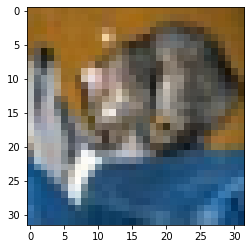

GroundTruth:  cat  


In [36]:
# Test data

dataiter = iter(test_dl)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images, normalize=True))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(1)))

In [37]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


In [38]:
correct_pred = {classname:0 for classname in classes}
total_pred = {classname:0 for classname in classes}

with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        for label, prediction in zip(labels, preds):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 54.5 %
Accuracy for class: car   is 69.0 %
Accuracy for class: bird  is 50.3 %
Accuracy for class: cat   is 20.1 %
Accuracy for class: deer  is 20.8 %
Accuracy for class: dog   is 69.8 %
Accuracy for class: frog  is 66.1 %
Accuracy for class: horse is 59.5 %
Accuracy for class: ship  is 61.0 %
Accuracy for class: truck is 72.2 %
